# Training a deep MLP on the MNIST dataset

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [18]:
print(X_train_full.shape, X_train_full.dtype) # 0-255 grayscale images

(60000, 28, 28) uint8


In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

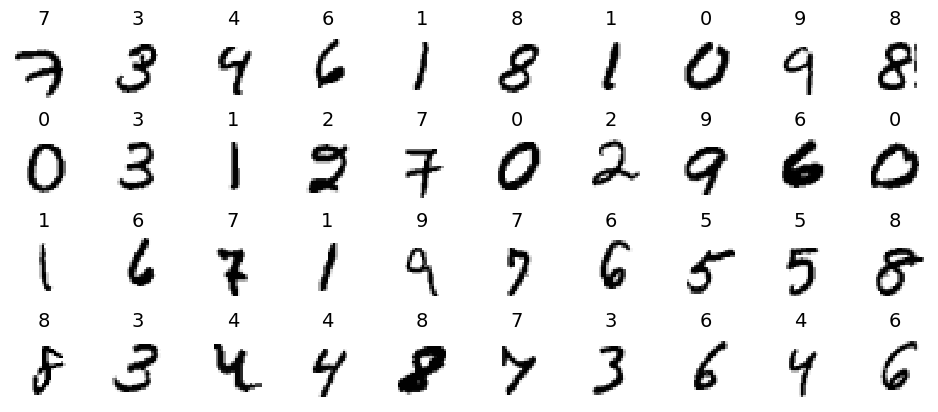

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

In [22]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=X_train_full.shape[1:]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,110 (1.60 MB)

 Trainable params: 419,110 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [25]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4694 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


Text(0, 0.5, 'Loss')

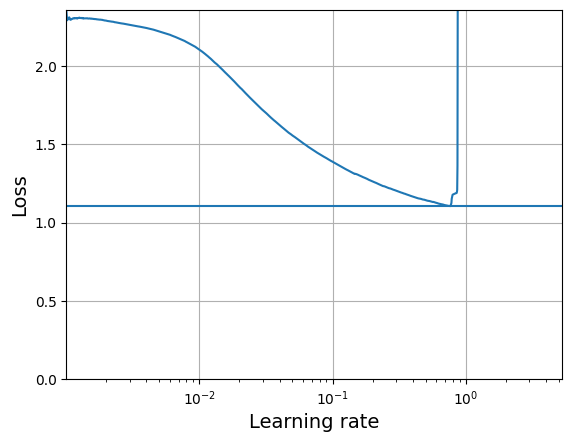

In [28]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [ ]:
num_train_samples = X_train_full.shape[0]
batch_size = 32
epochs = 100

steps_per_epoch = tf.math.ceil(num_train_samples / batch_size).numpy()
print(f"Steps per epoch: {steps_per_epoch}")

total_training_steps = steps_per_epoch * epochs
print(f"Total training steps: {total_training_steps}")

Steps per epoch: 1875.0
Total training steps: 187500.0


In [31]:
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=18750,
    decay_rate=0.96,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lrSchedule)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [32]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)

history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0976 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


In [33]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.0924 - loss: nan


[nan, 0.09799999743700027]